In [1]:
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName('test').getOrCreate()

train = spark.read.csv('./train.csv', header='true', inferSchema='true')
train.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: string (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |--

Now we will explore the label columns.

In [2]:
from pyspark.sql.functions import kurtosis, skewness
from pyspark.sql.types import FloatType

train.select('SalePrice').describe().show()
train.agg(skewness('SalePrice')).show()
train.agg(kurtosis('SalePrice')).show()
# Last parameter is error tolerance
quantile = train.approxQuantile('SalePrice', [0.25, 0.50, 0.75], 0.05)
quantileFrame = spark.createDataFrame([quantile], ['25%', '50%', '75%'])
quantileFrame.show()
train.stat.freqItems(['SalePrice'], 0.1).show()

+-------+------------------+
|summary|         SalePrice|
+-------+------------------+
|  count|              1460|
|   mean|180921.19589041095|
| stddev| 79442.50288288663|
|    min|             34900|
|    max|            755000|
+-------+------------------+

+-------------------+
|skewness(SalePrice)|
+-------------------+
| 1.8809407460340333|
+-------------------+

+-------------------+
|kurtosis(SalePrice)|
+-------------------+
|  6.509812011089432|
+-------------------+

+--------+--------+--------+
|     25%|     50%|     75%|
+--------+--------+--------+
|127000.0|157000.0|205000.0|
+--------+--------+--------+

+--------------------+
| SalePrice_freqItems|
+--------------------+
|[210000, 142125, ...|
+--------------------+



In [3]:
def findMissingValuesCols(df):
    numRows = df.count()
    nullCols = []
    for column in df.columns:
        c = df.filter(col(column).isNotNull()).count()
        if c != numRows:
            nullCols.append(c)
    return nullCols

missingCols = findMissingValuesCols(train)
print(missingCols)

[]


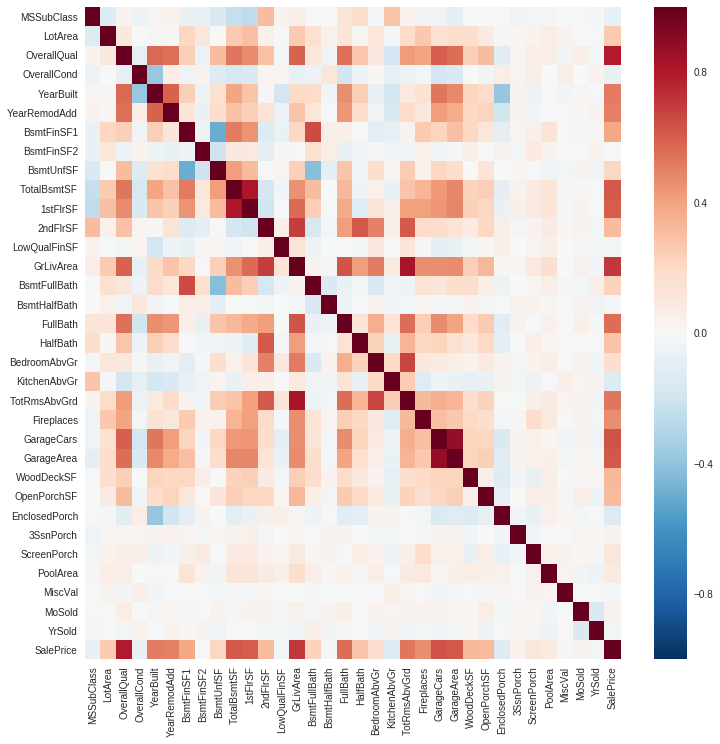

In [4]:
from pyspark.ml.stat import ChiSquareTest

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

numericCols = [dtype[0] for dtype in train.dtypes if dtype[1] == 'int']
numericCols.remove('Id')

corrAssembler = VectorAssembler(inputCols=numericCols, outputCol='corrFeatures')
corrTrain = corrAssembler.transform(train)
corrMat = Correlation.corr(corrTrain, 'corrFeatures').head()

pdf = corrMat[0].toArray()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))

sns.heatmap(pdf, 
            xticklabels=numericCols,
            yticklabels=numericCols)

In [5]:
from pyspark.ml.feature import StringIndexer

def autoIndexer(df, maxDistinct):
    stringTypes = [dtype[0] for dtype in train.dtypes if dtype[1] == 'string']
    numRows = train.count()
    indexed = df
    indexedCols = []
    for column in stringTypes:
        distinctCount = train.select(column).distinct().count()
        if distinctCount < maxDistinct:
            indexedCol = 'Indexed' + column
            indexedCols.append(indexedCol)
            indexer = StringIndexer(inputCol=column, outputCol=indexedCol)
            indexed = indexer.fit(indexed).transform(indexed)
            indexed = indexed.drop(column)
    return indexedCols, indexed

In [6]:
from pyspark.ml.feature import OneHotEncoderEstimator, OneHotEncoder
from pyspark.ml import Pipeline

oneHotEncodedColumns = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
                       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
                       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType',
                       'MiscFeature', ]
indexedOutputColumns = ['Indexed'+column for column in oneHotEncodedColumns]
oneHotEncodedOutputColumns = ['Encoded'+column for column in indexedOutputColumns]

indexers = [StringIndexer(inputCol=column, outputCol='Indexed'+column) for column in oneHotEncodedColumns]

oneHotEncoder = OneHotEncoderEstimator(inputCols=indexedOutputColumns, outputCols=oneHotEncodedOutputColumns)
# pipeline = Pipeline(stages=[*indexers, estimator])
# model = pipeline.fit(train)
# cleaned = model.transform(train)
# droppedColumns = [*oneHotEncodedColumns, *indexedOutputColumns]
# cleaned = cleaned.drop(*droppedColumns)
# cleaned.printSchema()

In [7]:
%%script false 

cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'
       'HeatingQC', 'KitchenQual', 'Functional']

In [8]:
cols = [dtype[0] for dtype in train.dtypes if dtype[1]!='string']
cols.remove('SalePrice')

from pyspark.ml.feature import ChiSqSelector

chiSqAssemblerOutCol = 'chiSqAssemblerFeatures'
chiSqAssembler = VectorAssembler(inputCols=cols, outputCol=chiSqAssemblerOutCol)
cleaned = chiSqAssembler.transform(train)
chiSqSelector = ChiSqSelector(numTopFeatures=10, featuresCol=chiSqAssemblerOutCol, outputCol='selectedFeatures', labelCol='SalePrice')
cleaned = chiSqSelector.fit(cleaned).transform(cleaned)
chiSqSelector.percentile

Param(parent='ChiSqSelector_473f9c7653b107bb2e21', name='percentile', doc='Percentile of features that selector will select, ordered by ascending p-value.')

In [9]:
cols = numericCols
cols.append('selectedFeatures')
finalAssembler = VectorAssembler(inputCols=cols, outputCol='features')
cols

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice',
 'selectedFeatures']

In [10]:
from pyspark.ml.regression import RandomForestRegressor

randomForest = RandomForestRegressor(featuresCol='features', labelCol='SalePrice', seed=42)


In [11]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# grid = ParamGridBuilder().addGrid(chiSqSelector.numTopFeatures, [10, 15, 20])\
#         .addGrid(randomForest.numTrees, [10, 15, 20]).build()

pipeline = Pipeline(stages=[*indexers, oneHotEncoder, chiSqAssembler, chiSqSelector, finalAssembler, randomForest])

# crossval = CrossValidator(estimator=pipeline, 
#                           estimatorParamMaps=grid, 
#                           evaluator=RegressionEvaluator(labelCol="SalePrice"), 
#                           numFolds=10)

model = pipeline.fit(train)
# model = crossval.fit(train)
df_r = model.transform(train)
evaluator=RegressionEvaluator(labelCol="SalePrice")
evaluator.evaluate(df_r,  {evaluator.metricName: "r2"})

0.9731777724456185

In [12]:
rfModel = model.stages[-1]

print('Number of features: ', rfModel.numFeatures)
print('Number of trees: ', rfModel.getNumTrees)
print('Feature Importances: ', rfModel.featureImportances)


Number of features:  44
Number of trees:  20
Feature Importances:  (44,[0,1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,27,28,29,31,32,33,34,35,36,37,38,39,40,41,42,43],[0.000587631254922,0.00353990612487,0.139170588016,0.000376230017114,0.0251714562564,0.00371073339499,0.0132218638791,0.000204866764608,0.00135537977208,0.00725169608664,0.00220399557534,0.000603635073825,0.0187751445928,9.30553713826e-05,0.00443417549528,0.00319600389704,0.000156240733157,0.00071381199278,6.73401522428e-05,0.00437480202481,0.00119923231083,0.00382750386524,0.00559815083691,0.00111535941798,0.00073029814671,6.02181073881e-05,0.000569127205812,0.000361522860541,0.000258688801703,0.000975648024982,0.502700106011,0.00275075376543,0.139892650733,0.000364939332451,0.00100031067309,0.0276705491487,0.00592175564307,5.65421343759e-05,0.0605421784007,0.00709027239231,0.00810563571193])


In [13]:
from pyspark.sql.types import IntegerType

test = spark.read.csv('./test.csv', header='true', inferSchema='true')
test = test.withColumn('BsmtFinSF1', test['BsmtFinSF1'].cast(IntegerType()))
test = test.withColumn('BsmtFinSF2', test['BsmtFinSF2'].cast(IntegerType()))
train.select('BsmtFinSF1').printSchema()
test.select('BsmtFinSF1').printSchema()

predictions = model.transform(test)
predictions

root
 |-- BsmtFinSF1: integer (nullable = true)

root
 |-- BsmtFinSF1: integer (nullable = true)



IllegalArgumentException: 'Data type StringType of column BsmtUnfSF is not supported.\nData type StringType of column TotalBsmtSF is not supported.\nData type StringType of column BsmtFullBath is not supported.\nData type StringType of column BsmtHalfBath is not supported.\nData type StringType of column GarageCars is not supported.\nData type StringType of column GarageArea is not supported.'

In [ ]:

cols = indexed.columns[:]
cols.remove('SalePrice')
cols.remove('Id')
print(cols)
assembler = VectorAssembler(inputCols=cols, outputCol='features')
assembled = assembler.transform(indexed)

In [ ]:
from pyspark.ml.stat import ChiSquareTest, Correlation

r = ChiSquareTest.test(assembled, 'features', 'SalePrice')
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))

r.show()

In [ ]:
r1 = Correlation.corr(assembled, 'features')
r1.head(1)

In [ ]:
train.crosstab('OverallQual', 'OverallCond').show()

In [ ]:
# train.corr('OverallCond', 'OverallQual')
# train.dtypes
train.select('OverallCond').groupby('OverallCond')